In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Distâncias em mm
# Tempos em ms
# Frequencias em kHz
# Fases em ciclos (360 degrees)

# Definindo a geometria padrao:
delta0 = 2  # (mm) distância da superficie do emissor à grade que proteje o emissor
separacao0 = 27 # (mm) distância entre os emissores (entre as grades dos emissores)

c = 340 # (mm/ms) = (m/s)
f = 40 # (kHz)


# Criar os emissores:
def criarEmissores(Amps=[1, 1], separacao=separacao0, delta=delta0, fases=[0,0] ):
  z10 = -delta
  z20 = separacao + delta
  DIR1 = +1
  DIR2 = -1
  Emissor1 = { 'Amp':Amps[0], 'z':z10, 'DIR':DIR1, 'fase':fases[0]}
  Emissor2 = { 'Amp':Amps[1], 'z':z20, 'DIR':DIR2, 'fase':fases[1]}
  Emissores = [ Emissor1, Emissor2 ]
  return Emissores

def calculaEmissoresComNreflexoes(Emissores, N, Dfase = 0, Fontes = []):
  #Fonte = {'Amp':, 'z':, 'DIR':, 'faseP':, 'faseU':}

  Emissores_rN = [emissor.copy() for emissor in Emissores]
  Fonte_rN = [fonte.copy() for fonte in Fontes]

  Emissores_rN[1]['fase'] = Emissores[1]['fase'] + Dfase
  dz12 = abs( Emissores_rN[1]['z'] - Emissores_rN[0]['z'] )
  for qE in [0,1]:
    AmpR = Emissores_rN[qE]['Amp']
    faseP_R = Emissores_rN[qE]['fase']
    if ((N%2)==1): # N e impar
      zR0 = Emissores_rN[1-qE]['z']
      DIR_R = -Emissores_rN[qE]['DIR']
      faseU_R = (faseP_R + Emissores_rN[qE]['DIR']*0.25) + 0.5
    else:
      zR0 = Emissores_rN[qE]['z']
      DIR_R = Emissores_rN[qE]['DIR']
      faseU_R = (faseP_R + Emissores_rN[qE]['DIR']*0.25)
    dzR = -DIR_R*N*dz12
    FonteAtu = {'Amp':AmpR, 'z':zR0+dzR, 'DIR': DIR_R, 'faseP':faseP_R, 'faseU':faseU_R}
    Fonte_rN.append( FonteAtu )
  return Fonte_rN


def calculaOnda( Fontes, Zs=np.linspace(0,separacao0,1000), f = 40, c = 340,
                atenuacao = lambda Amp0, DISTs: (Amp0/(DISTs)) ):
  Lambda = c/f
  k = 2*(np.pi)/Lambda
  P = np.zeros_like(Zs,dtype='complex')
  U = np.zeros_like(Zs,dtype='complex')
  for fonte in Fontes:
    DISTs = abs( Zs-fonte['z'] )
    P += atenuacao(fonte['Amp'],DISTs)*np.exp( -1j*(k*DISTs + 2*np.pi*fonte['faseP']) )
    U += atenuacao(fonte['Amp'],DISTs)*np.exp( -1j*(k*DISTs + 2*np.pi*fonte['faseU']) )
  return P, U

[{'Amp': 1, 'z': -2, 'DIR': 1, 'faseP': 0, 'faseU': 0.25}, {'Amp': 1, 'z': 29, 'DIR': -1, 'faseP': 0, 'faseU': -0.25}]


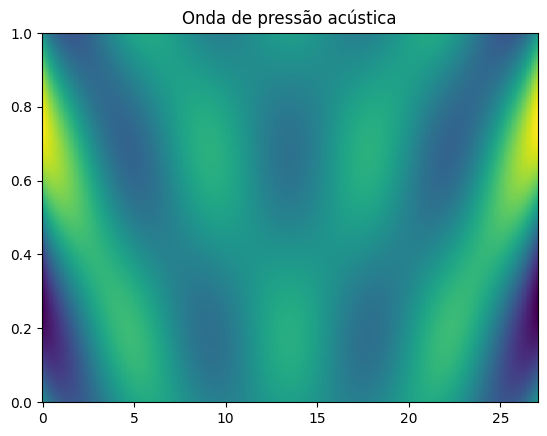

In [ ]:
fase = 0
Emissores = criarEmissores(Amps=[1,1]);

Fontes0 = calculaEmissoresComNreflexoes(Emissores, 0, fase)
#Fontes1 = calculaEmissoresComNreflexoes(Emissores, 1, fase)
#Fontes01 = calculaEmissoresComNreflexoes(Emissores, 1, fase, Fontes=Fontes0)

print( Fontes0 )

Zs = np.linspace( 0, separacao0, 300 )

P0,U0 = calculaOnda( Fontes0, Zs )
#P1,U1 = calculaOnda( Fontes1, Zs  )
#P01,U01 = calculaOnda( Fontes01, Zs )


def mostraReal( PouU, Zs, titulo=None ):
  Ts = np.linspace(0,1, 500)
  PouUReal = []
  for t in Ts:
    PouUReal.append( np.real( PouU*np.exp(-1j*2*np.pi*t) ) )
  plt.figure()
  plt.pcolor(Zs,Ts,PouUReal)
  if titulo is not None:
    plt.title( titulo )
  plt.show()

mostraReal( P0, Zs, 'Onda de pressão acústica' )

#mostraReal( P1, Zs, 'P1' )
#mostraReal( U1, Zs, 'U1' )

#mostraReal( P01, Zs, 'P01' )
#mostraReal( U01, Zs, 'U01' )




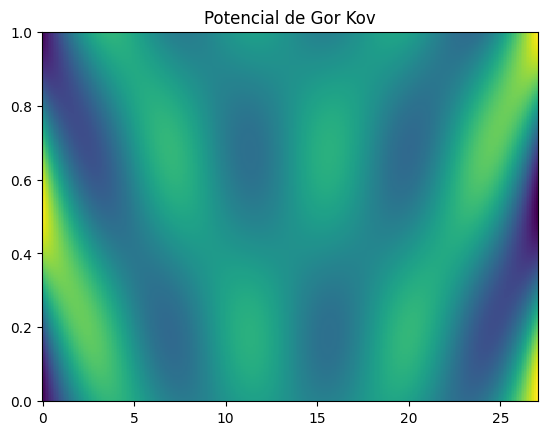

In [ ]:
mostraReal( U0, Zs, 'Potencial de Gor Kov' )

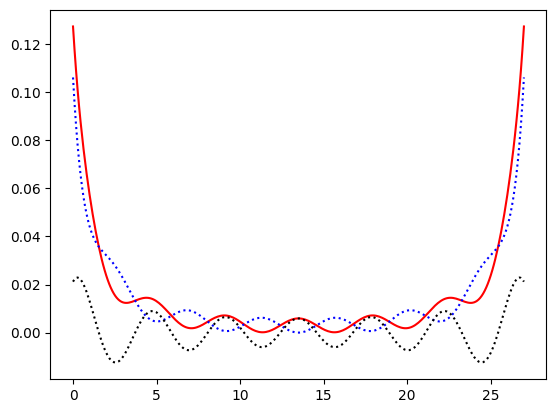

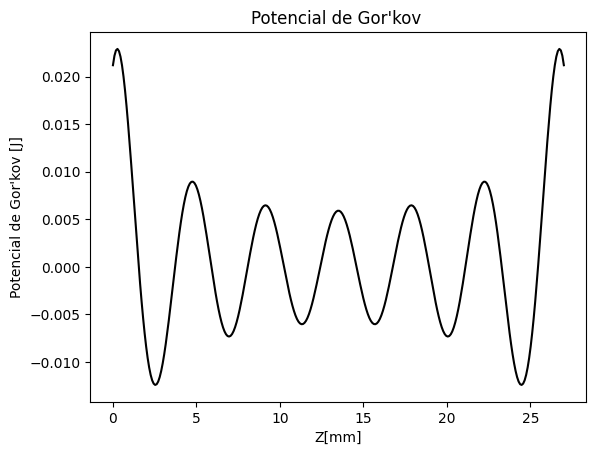

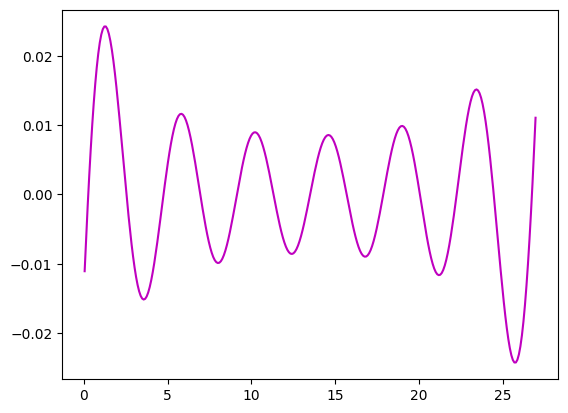

In [ ]:
def calculaVar( PouU ):
  varPouU = 0.5*((np.abs(PouU))**2)
  return varPouU

def calculaPotencial( P, U ):
  varP = calculaVar(P)
  varU = calculaVar(U)
  Potencial = varP-varU
  return Potencial

def calculaForca( Potencial, Zs ):
  Forca = -np.diff(Potencial) / np.diff(Zs)
  zForca = (Zs[:-1] + Zs[1:])/2
  return zForca, Forca

Emissores_linha = criarEmissores( Amps=[1, 1])
Fontes0_linha = calculaEmissoresComNreflexoes(Emissores_linha, 0, fase)
Fontes01_linha = calculaEmissoresComNreflexoes(Emissores_linha, 1, fase, Fontes=Fontes0_linha)
P0sA,U0sA = calculaOnda( Fontes01_linha, Zs )

vP0 = calculaVar( P0sA )
vU0 = calculaVar( U0sA )
Pot = calculaPotencial( P0sA, U0sA )
zF, F = calculaForca( Pot, Zs )

plt.figure()
plt.plot( Zs, vP0, '-r')
plt.plot( Zs, vU0, ':b')
plt.plot( Zs, vP0-vU0, ':k')
#plt.ylim( (-0.01,0.01) )
plt.show()


plt.figure()
plt.title("Potencial de Gor'kov ")
plt.xlabel("Z[mm]")
plt.ylabel("Potencial de Gor'kov [J]")
plt.plot( Zs, Pot, '-k' )
plt.show()

plt.figure()
plt.plot( zF, F, '-m' )
plt.show()


In [ ]:
Emissores_sA

[{'Amp': 1, 'z': 0, 'DIR': 1, 'fase': 0},
 {'Amp': 0, 'z': 27, 'DIR': -1, 'fase': 0}]

In [ ]:
Fontes01_sA

[{'Amp': 1, 'z': 0, 'DIR': 1, 'faseP': 0, 'faseU': 0.25},
 {'Amp': 0, 'z': 27, 'DIR': -1, 'faseP': 0, 'faseU': -0.25},
 {'Amp': 1, 'z': 54, 'DIR': -1, 'faseP': 0, 'faseU': 0.25},
 {'Amp': 0, 'z': -27, 'DIR': 1, 'faseP': 0, 'faseU': -0.25}]